In [10]:
# Import required libraries
import pandas as pd
import numpy as np
import seaborn as sns
import glob
import re
import sqlite3
import matplotlib.pyplot as plt
import pickle
import pyarrow
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.linear_model import LassoCV
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score
from typing import Union, Tuple

In [11]:
# 3. Data Integration (extract)
## Extracting data from files and combining it into one single data frame

In [12]:
def extract(file_path: str) -> pd.DataFrame:
    # created 3 different lists which contain the data files - 1 for each type of file
    csv_files = glob.glob(file_path + '*.csv')
    json_files = glob.glob(file_path + '*.json')
    parquet_files = glob.glob(file_path + '*.parquet')

    # created 3 different empty lists of each file type to store the dataframes
    csv_list = []
    json_list = []
    parquet_list = []

    # loop through the list of glob csv files and read/convert each one into a data frame
    # and append it to the list that will contain the newly converted csv data frames
    for csv in csv_files:
      temp_df = pd.read_csv(csv)
      csv_list.append(temp_df)

    # concatenate the newly converted list of csv data frames into one
    csv_df = pd.concat(csv_list, axis=0)
    print(f"CSV shape: {csv_df.shape} \n")
    csv_df.head()

    # loop through the list of glob JSON files and read/convert each one into a data frame
    # and append it to the list that will contain the newly converted JSON data frames
    for json in json_files:
        temp_df = pd.read_json(json, lines=True)
        json_list.append(temp_df)

    # concatenate the newly converted list of JSON data frames into one
    json_df = pd.concat(json_list, axis=0)
    print(f"JSON shape: {json_df.shape} \n")
    json_df.head()

    # loop through the list of glob parquet files and read/convert each one into a data frame
    # and append it to the list that will contain the newly converted parquet data frames
    for pq in parquet_files:
        temp_df = pd.read_parquet(pq)
        parquet_list.append(temp_df)

    # concatenate the list of parquet data frames into one
    parquet_df = pd.concat(parquet_list, axis=0)
    print(f"Parquet shape: {parquet_df.shape} \n")
    parquet_df.head()

    # combine all dataframes into one and return it
    combined_df = pd.concat([csv_df, json_df, parquet_df], ignore_index=True)
    return combined_df

In [13]:
# directory to access for the data files we need is called 'data' and the file path is '/content/data/'
# the file path to obtain the data may change obviously, it is dependent upon the machine it is ran and where the data is stored
path = './data/'
data = extract(path)
print(f"Combined dataframes shape: {data.shape}")
data.head()

CSV shape: (3003, 79) 

JSON shape: (26805, 79) 

Parquet shape: (31320, 79) 

Combined dataframes shape: (61128, 79)


,Destination Port,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,...,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,80,311,2,0,12,0,6,6,6.000000,0.00000,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
1,61513,8,1,1,6,6,6,6,6.000000,0.00000,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
2,443,5919990,9,10,1714,4904,581,0,190.444444,255.01476,...,32,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
3,53,226,2,2,62,184,31,31,31.000000,0.00000,...,40,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
4,443,390972,5,5,837,1969,561,0,167.400000,237.27895,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN


In [14]:
## Data has been extracted, combined into one single data frame; now it is ready for transformation.

In [15]:
# 4. Data Transformation (Transform)

In [16]:
# check the current data types with data.info() as it won't truncate it unlike data.dtypes()
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61128 entries, 0 to 61127
Data columns (total 79 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0    Destination Port             61128 non-null  int64  
 1    Flow Duration                61128 non-null  int64  
 2    Total Fwd Packets            61128 non-null  int64  
 3    Total Backward Packets       61128 non-null  int64  
 4   Total Length of Fwd Packets   61128 non-null  int64  
 5    Total Length of Bwd Packets  61128 non-null  int64  
 6    Fwd Packet Length Max        61128 non-null  int64  
 7    Fwd Packet Length Min        61128 non-null  int64  
 8    Fwd Packet Length Mean       61128 non-null  float64
 9    Fwd Packet Length Std        61128 non-null  float64
 10  Bwd Packet Length Max         61128 non-null  int64  
 11   Bwd Packet Length Min        61128 non-null  int64  
 12   Bwd Packet Length Mean       61128 non-null  float64
 13   

In [17]:
# remove the white space from column names
data.columns = data.columns.str.strip()

In [18]:
# remove 'Heartbleed' attack data
data = data[data['Label'] != 'Heartbleed']

In [19]:
# display the number of missing data per column in our 'data' data frame
data.isna().sum()

Destination Port               0
Flow Duration                  0
Total Fwd Packets              0
Total Backward Packets         0
Total Length of Fwd Packets    0
                              ..
Idle Mean                      0
Idle Std                       0
Idle Max                       0
Idle Min                       0
Label                          0
Length: 79, dtype: int64

In [20]:
# the following statement is used to determine the total number of missing values
print(f'Total number of missing values: {data.isna().sum().sum()}')

Total number of missing values: 180


In [21]:
# drop duplicate data values and display the shape to determine if the row (x) value is less than the original value of 61_128
data = data.drop_duplicates()
data.shape

(48552, 79)

In [22]:
# print the total number of missing values again after dropping duplicates to determine if there are any
# remaining so that they can be handled accordingly
print(f'Total number of missing values: {data.isna().sum().sum()}')

Total number of missing values: 10


In [23]:
# handle out-of-range and outlier data: infinite values are replaced with NaNs, which are then filled with column means.

# list to contain columns with infinite values
cols_with_infinite = []

# loop through each column that is a 'number' type (int64, float64) to check for infinite values
for column in data.select_dtypes(include=[np.number]).columns:
    if data[column].apply(np.isinf).any():
        cols_with_infinite.append(column)
        count_infinite = data[column].apply(np.isinf).sum()
        print(f"Column '{column}' has {count_infinite} infinite values.")

# display columns with infinite values
print(f"Columns with infinite values: {cols_with_infinite}")

# check for existing NaN values before replacing infinite values - should be 10
initial_nans_count = data[cols_with_infinite].isna().sum()
print(f"Initial count of NaN values in 'Flow Bytes/s' and 'Flow Packets/s': \n{initial_nans_count}")

# replace all infinite values with NaN in the 'Flow Bytes/s' & 'Flow Packets/s' columns
data[cols_with_infinite] = data[cols_with_infinite].replace([np.inf, -np.inf], np.nan)

# verify that all infinite values in the 'Flow Bytes/s' & 'Flow Packets/s' columns have been replaced with NaN
for column in cols_with_infinite:
    if data[column].apply(np.isinf).any():
        print(f"Error: Column '{column}' still contains infinite values.")
    else:
        print(f"Success: Column '{column}' no longer contains infinite values.")

# count the number of NaNs in the 'Flow Bytes/s' & 'Flow Packets/s' columns after replacing infinite values
nans_count_after_replacement = data[cols_with_infinite].isna().sum()
print(f"Count of NaN values in 'Flow Bytes/s' and 'Flow Packets/s' after replacing infinite values: \n{nans_count_after_replacement}")

# fill NaNs with the mean of the column in the 'Flow Bytes/s' & 'Flow Packets/s' columns
data[cols_with_infinite] = data[cols_with_infinite].fillna(data[cols_with_infinite].mean())

# verify that there are no more NaNs in the 'Flow Bytes/s' & 'Flow Packets/s' columns
nans_count_after_filling = data[cols_with_infinite].isna().sum()
print(f"Count of NaN values in 'Flow Bytes/s' and 'Flow Packets/s' after filling NaNs: \n{nans_count_after_filling}")

Column 'Flow Bytes/s' has 3 infinite values.
Column 'Flow Packets/s' has 5 infinite values.
Columns with infinite values: ['Flow Bytes/s', 'Flow Packets/s']
Initial count of NaN values in 'Flow Bytes/s' and 'Flow Packets/s': 
Flow Bytes/s      6
Flow Packets/s    4
dtype: int64
Success: Column 'Flow Bytes/s' no longer contains infinite values.
Success: Column 'Flow Packets/s' no longer contains infinite values.
Count of NaN values in 'Flow Bytes/s' and 'Flow Packets/s' after replacing infinite values: 
Flow Bytes/s      9
Flow Packets/s    9
dtype: int64
Count of NaN values in 'Flow Bytes/s' and 'Flow Packets/s' after filling NaNs: 
Flow Bytes/s      0
Flow Packets/s    0
dtype: int64


In [24]:
# print the total number of missing values again to make sure that it is 0 and that all missing values have been handled
print(f'Total number of missing values: {data.isna().sum().sum()}')

Total number of missing values: 0


In [25]:
## Data has been transformed and is ready for loading to a csv file and database

In [26]:
# 5. Data Storage (Load)

In [27]:
# sqlite database and table names variables created for cleaned data
database_name = 'ide_cleaned_db'
table_name = 'ntdl_cleaned'

In [28]:
# load the data to a csv file
def load_to_csv(data_frame: pd.DataFrame, file_name: str) -> None:
    data_frame.to_csv(file_name, index=False)

In [29]:
# load the data to a sqlite database
def load_to_database(data_frame: pd.DataFrame, db_name: str, t_name) -> None:
    # add an id column to the data frame for the database as the primary key
    if 'id' not in data_frame.columns:
        data_frame.reset_index(drop=True, inplace=True)
        data_frame.insert(0, 'id', data_frame.index + 1)

    # create a connection to sqlite
    sqlconnection = sqlite3.connect(db_name)

    # load data frame into sqlite specifying table name, SQL connection, if the table exists then replace it, don't index it, and have id be the primary key
    data_frame.to_sql(t_name, sqlconnection, if_exists="replace", index=False, dtype={"id": "INTEGER PRIMARY KEY"})

    # close the connection
    sqlconnection.close()

    # drop the 'id' column as it's only needed when loading to a database
    if 'id' in data.columns:
        data.drop(columns=['id'], inplace=True)

In [30]:
# call the 'load_to_csv' and 'load_to_database' functions to perform those actions / tasks
load_to_csv(data_frame=data, file_name="ide_data_cleaned.csv")
load_to_database(data_frame=data, db_name=database_name, t_name=table_name)

In [31]:
# connect to the database and create a cursor
connect = sqlite3.connect(database_name)
# database cursor is used to query a database and fetch results
cur = connect.cursor()

In [32]:
# return values for each row in the ntdl_cleaned table:
ntdl_query = f"PRAGMA table_info({table_name})"
ntdl_result = cur.execute(ntdl_query)
ntdl_result.fetchall()

[(0, 'id', 'INTEGER', 0, None, 1),
 (1, 'Destination Port', 'INTEGER', 0, None, 0),
 (2, 'Flow Duration', 'INTEGER', 0, None, 0),
 (3, 'Total Fwd Packets', 'INTEGER', 0, None, 0),
 (4, 'Total Backward Packets', 'INTEGER', 0, None, 0),
 (5, 'Total Length of Fwd Packets', 'INTEGER', 0, None, 0),
 (6, 'Total Length of Bwd Packets', 'INTEGER', 0, None, 0),
 (7, 'Fwd Packet Length Max', 'INTEGER', 0, None, 0),
 (8, 'Fwd Packet Length Min', 'INTEGER', 0, None, 0),
 (9, 'Fwd Packet Length Mean', 'REAL', 0, None, 0),
 (10, 'Fwd Packet Length Std', 'REAL', 0, None, 0),
 (11, 'Bwd Packet Length Max', 'INTEGER', 0, None, 0),
 (12, 'Bwd Packet Length Min', 'INTEGER', 0, None, 0),
 (13, 'Bwd Packet Length Mean', 'REAL', 0, None, 0),
 (14, 'Bwd Packet Length Std', 'REAL', 0, None, 0),
 (15, 'Flow Bytes/s', 'REAL', 0, None, 0),
 (16, 'Flow Packets/s', 'REAL', 0, None, 0),
 (17, 'Flow IAT Mean', 'REAL', 0, None, 0),
 (18, 'Flow IAT Std', 'REAL', 0, None, 0),
 (19, 'Flow IAT Max', 'INTEGER', 0, None, 0

In [33]:
# close the connection
connect.close()

In [34]:
## Data has been loaded to a csv file and a SQLite database and is ready for exploratory data analysis

In [35]:
# 6. Reading Data

In [36]:
# reading the data (6.1) into a pandas dataframe
data = pd.read_csv("ide_data_cleaned.csv")

In [37]:
# 7. Exploratory Data Analysis

In [38]:
## Univariate Analysis

In [39]:
# determine the shape of the data:
shape = data.shape
print(f"The dataset contains {shape[0]} rows and {shape[1]} columns.")

The dataset contains 48552 rows and 79 columns.


In [40]:
# unify the columns/features names
def unify_column_name(name: str) -> str:
    name = name.lower().replace(' ', '_')  # replace all spaces with underscores
    name = re.sub(r'[^\w]', '', name)  # remove all non-alphanumeric characters
    if name.endswith('ss'):
        name = name[:-1] # if the name ends with 'ss', remove the 'ss' and only have it be 's'
    return name

data.columns = data.columns.map(lambda x: unify_column_name(x))
print(f"Unified column names: \n{data.columns}")

Unified column names: 
Index(['destination_port', 'flow_duration', 'total_fwd_packets',
       'total_backward_packets', 'total_length_of_fwd_packets',
       'total_length_of_bwd_packets', 'fwd_packet_length_max',
       'fwd_packet_length_min', 'fwd_packet_length_mean',
       'fwd_packet_length_std', 'bwd_packet_length_max',
       'bwd_packet_length_min', 'bwd_packet_length_mean',
       'bwd_packet_length_std', 'flow_bytes', 'flow_packets', 'flow_iat_mean',
       'flow_iat_std', 'flow_iat_max', 'flow_iat_min', 'fwd_iat_total',
       'fwd_iat_mean', 'fwd_iat_std', 'fwd_iat_max', 'fwd_iat_min',
       'bwd_iat_total', 'bwd_iat_mean', 'bwd_iat_std', 'bwd_iat_max',
       'bwd_iat_min', 'fwd_psh_flags', 'bwd_psh_flags', 'fwd_urg_flags',
       'bwd_urg_flags', 'fwd_header_length', 'bwd_header_length',
       'fwd_packets', 'bwd_packets', 'min_packet_length', 'max_packet_length',
       'packet_length_mean', 'packet_length_std', 'packet_length_variance',
       'fin_flag_count', 'syn

In [41]:
# identify the unique values in the class label variable
unique_labels = data['label'].unique()
print(f"The unique values in the 'label' column are: {unique_labels}")

The unique values in the 'label' column are: ['BENIGN' 'DoS Hulk' 'DoS Slowhttptest' 'DoS GoldenEye']


In [42]:
# calculate statistics of data
stats = data.describe()
print(f"Statistics of data: \n{stats}")

Statistics of data: 
       destination_port  flow_duration  total_fwd_packets  \
count      48552.000000   4.855200e+04       48552.000000   
mean        1027.732534   4.911535e+07           6.224399   
std         6797.845592   4.268674e+07          10.920432   
min            0.000000   0.000000e+00           1.000000   
25%           80.000000   9.783540e+06           4.000000   
50%           80.000000   4.212188e+07           6.000000   
75%           80.000000   9.810088e+07           8.000000   
max        65416.000000   1.199999e+08        1235.000000   

       total_backward_packets  total_length_of_fwd_packets  \
count            48552.000000                 48552.000000   
mean                 4.626277                   434.580718   
std                 16.184127                  1968.548897   
min                  0.000000                     0.000000   
25%                  1.000000                    68.000000   
50%                  5.000000                   351.00000

In [43]:
# create variable that contains only values that are of type int64 or float64 to calculate statistics of data
numeric_data = data.select_dtypes(include=[np.number])

In [44]:
# calculate mean of data
mean = numeric_data.mean()
print(f"Mean of each column: \n{mean}")

Mean of each column: 
destination_port               1.027733e+03
flow_duration                  4.911535e+07
total_fwd_packets              6.224399e+00
total_backward_packets         4.626277e+00
total_length_of_fwd_packets    4.345807e+02
                                   ...     
active_min                     4.980307e+05
idle_mean                      4.304260e+07
idle_std                       1.285873e+06
idle_max                       4.430345e+07
idle_min                       4.200280e+07
Length: 78, dtype: float64


In [45]:
# calculate variance of data
variance = numeric_data.var()
print(f"Variance of each column: \n{variance}")

Variance of each column: 
destination_port               4.621070e+07
flow_duration                  1.822158e+15
total_fwd_packets              1.192558e+02
total_backward_packets         2.619260e+02
total_length_of_fwd_packets    3.875185e+06
                                   ...     
active_min                     2.970423e+12
idle_mean                      1.894786e+15
idle_std                       3.705565e+13
idle_max                       1.887040e+15
idle_min                       1.939427e+15
Length: 78, dtype: float64


In [46]:
# calculate standard deviation of data
std = numeric_data.std()
print(f"Standard deviation of each column: \n{std}")

Standard deviation of each column: 
destination_port               6.797846e+03
flow_duration                  4.268674e+07
total_fwd_packets              1.092043e+01
total_backward_packets         1.618413e+01
total_length_of_fwd_packets    1.968549e+03
                                   ...     
active_min                     1.723491e+06
idle_mean                      4.352914e+07
idle_std                       6.087335e+06
idle_max                       4.344007e+07
idle_min                       4.403892e+07
Length: 78, dtype: float64


In [47]:
# identify low variance columns
limit = 0.01
low_var_columns = variance[variance < limit].index.tolist()
print(f"Columns with low or near zero variance: {low_var_columns}")

Columns with low or near zero variance: ['bwd_psh_flags', 'fwd_urg_flags', 'bwd_urg_flags', 'rst_flag_count', 'cwe_flag_count', 'ece_flag_count', 'fwd_avg_bytesbulk', 'fwd_avg_packetsbulk', 'fwd_avg_bulk_rate', 'bwd_avg_bytesbulk', 'bwd_avg_packetsbulk', 'bwd_avg_bulk_rate']


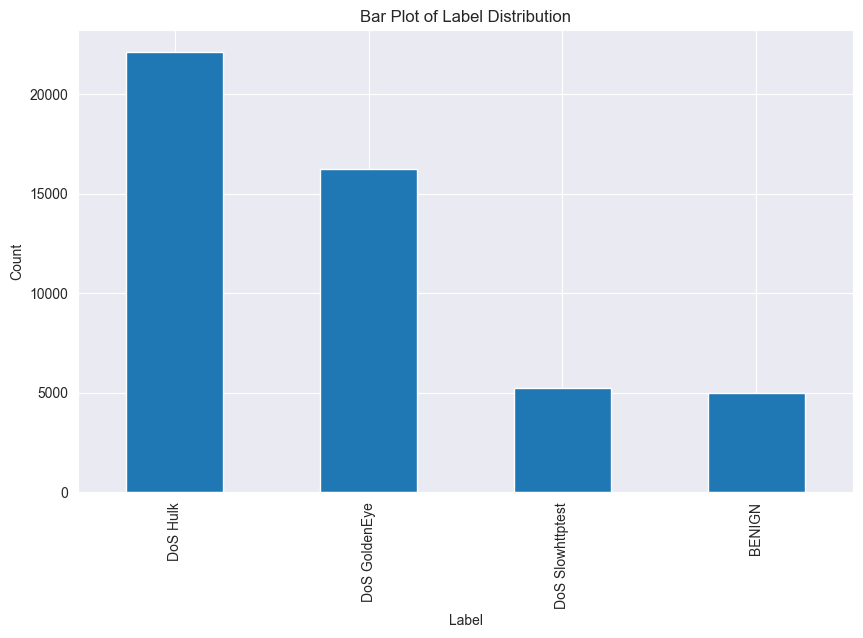

In [48]:
# visualizations for specific columns with bar plots, pie charts, and boxplot

# bar plot for 'label' column
plt.figure(figsize=(10,6))
data['label'].value_counts().plot(kind='bar')
plt.title('Bar Plot of Label Distribution')
plt.xlabel('Label')
plt.ylabel('Count')
plt.show()

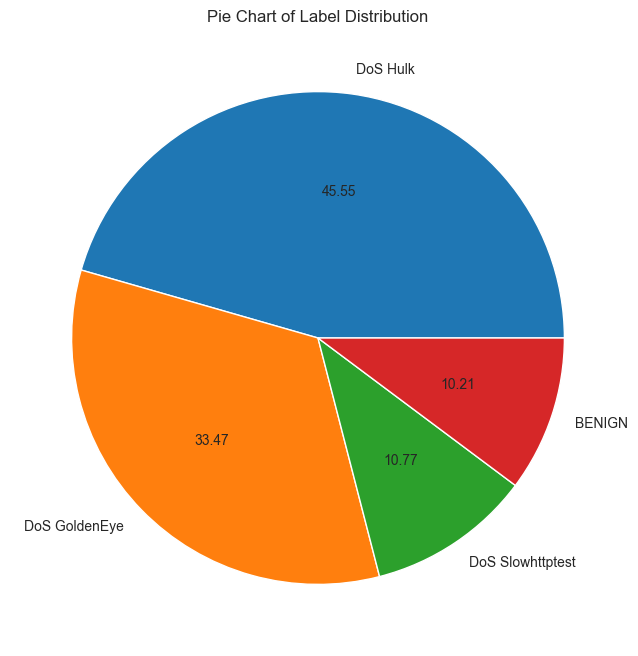

In [49]:
# pie chart for 'label' column
plt.figure(figsize=(8, 8))
data['label'].value_counts().plot(kind='pie', autopct='%1.2f')
plt.title('Pie Chart of Label Distribution')
plt.ylabel('')
plt.show()

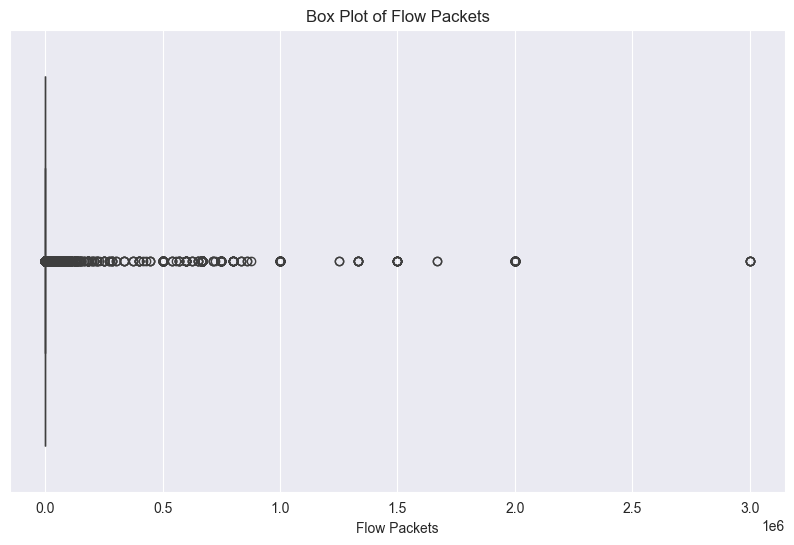

In [50]:
# box plot for 'flow_packets' column
plt.figure(figsize=(10, 6))
sns.boxplot(x=data['flow_packets'])
plt.title('Box Plot of Flow Packets')
plt.xlabel('Flow Packets')
plt.show()

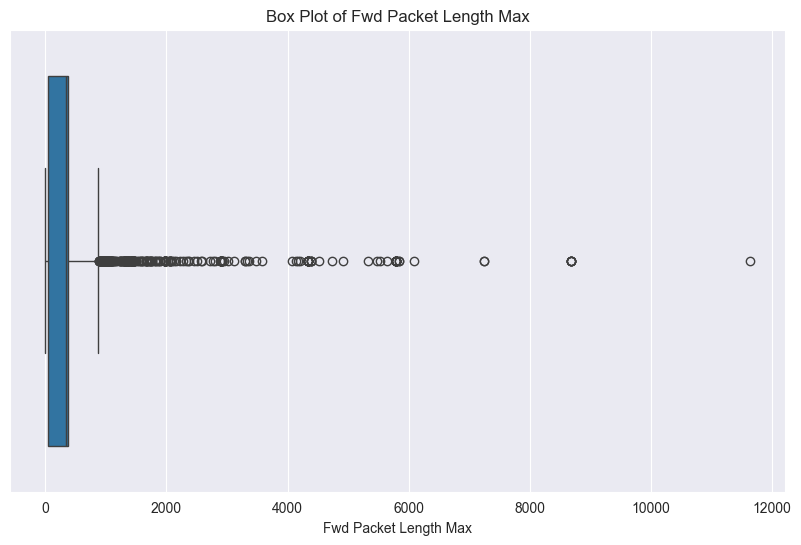

In [51]:
# box plot for 'fwd_packet_length_max' column
plt.figure(figsize=(10, 6))
sns.boxplot(x=data['fwd_packet_length_max'])
plt.title('Box Plot of Fwd Packet Length Max')
plt.xlabel('Fwd Packet Length Max')
plt.show()

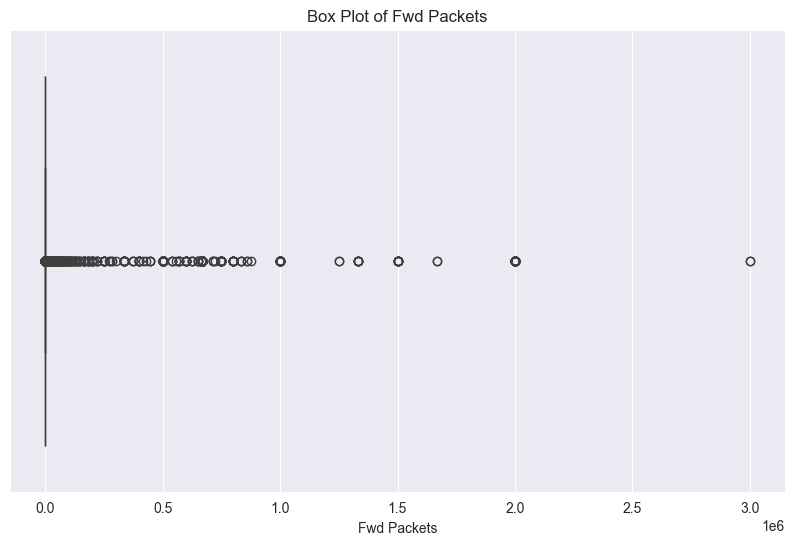

In [52]:
# box plot for 'fwd_packets' column
plt.figure(figsize=(10, 6))
sns.boxplot(x=data['fwd_packets'])
plt.title('Box Plot of Fwd Packets')
plt.xlabel('Fwd Packets')
plt.show()

In [53]:
## Bivariate Analysis

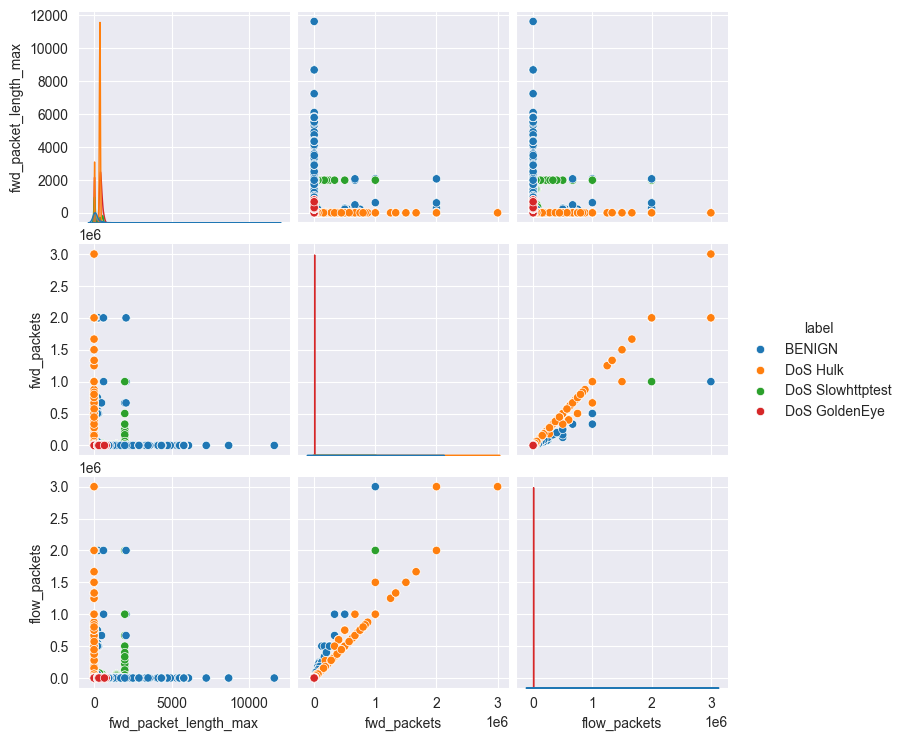

In [54]:
# generating a pair plot for the same columns we performed univariate analysis on
columns_for_pair_plot = ['fwd_packet_length_max', 'fwd_packets', 'flow_packets', 'label']
sns.pairplot(data[columns_for_pair_plot], hue='label')
plt.show()

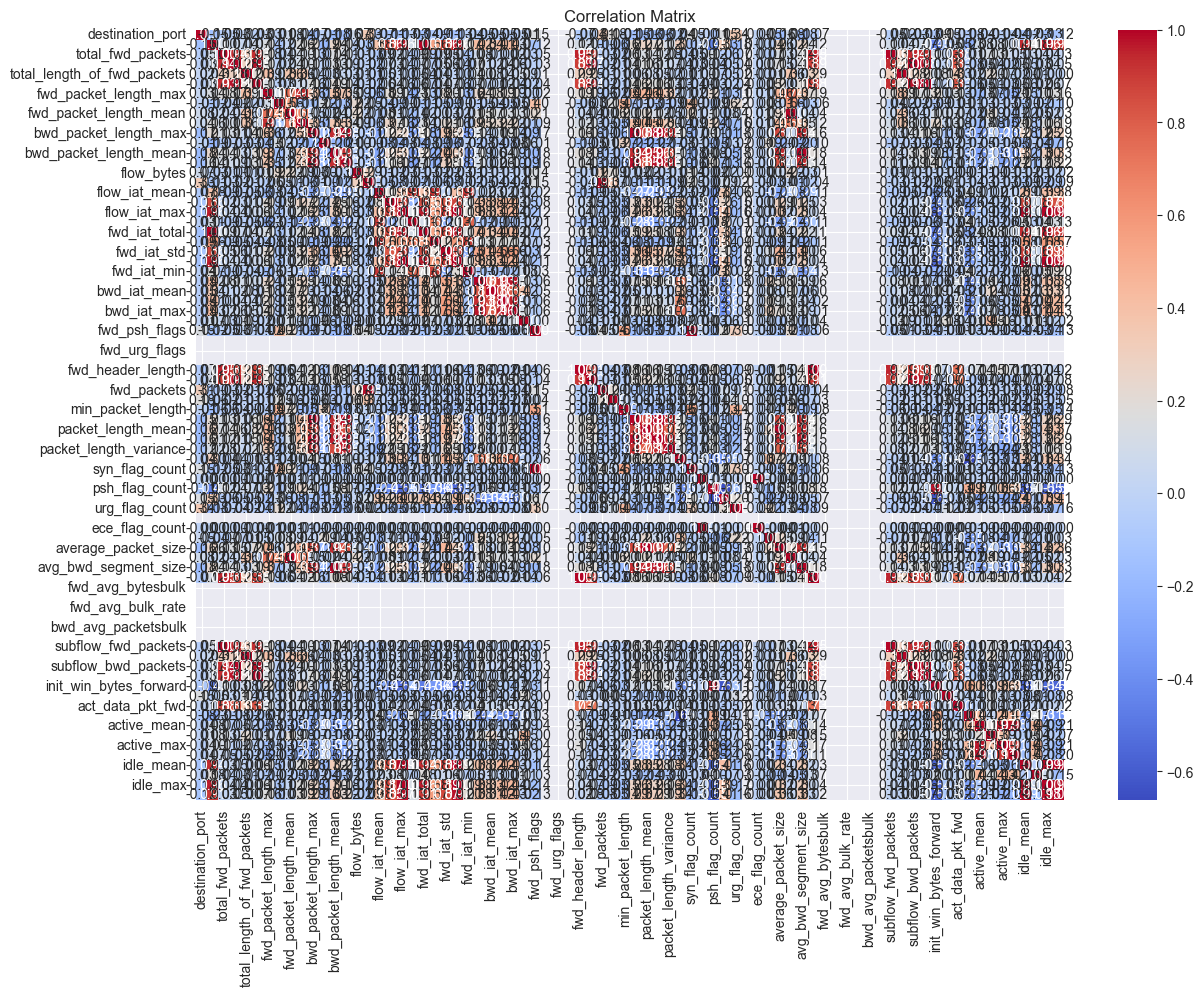

In [55]:
# computing and generating the correlation matrix
correlation_matrix = numeric_data.corr()
plt.figure(figsize=(14, 10))
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

In [56]:
## Exploratory data analysis has been completed now data is ready for preprocessing.

In [57]:
# 8. Data Preprocessing

In [58]:
# apply lambda function to create binary labels. 0 for benign, 1 for attack
data['binary_label'] = data['label'].apply(lambda x: 0 if x.lower() == 'benign' else 1)

In [59]:
# splitting the dataset into train, test, and validation splits

# defines features (X) and target (y)
X = data.drop(columns=['label', 'binary_label']) # drop the label & binary_label column from features
y = data['binary_label'] # binary labels - the label column is the target

# split data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# split the training set further into training and validation sets (10% of training data for validation)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.10, random_state=42, stratify=y_train)

# print the shapes of the resulting splits to verify
print(f"Training set shape: X_train: {X_train.shape}, y_train: {y_train.shape}")
print(f"Validation set shape: X_val: {X_val.shape}, y_val: {y_val.shape}")
print(f"Testing set shape: X_test: {X_test.shape}, y_test: {y_test.shape}")

Training set shape: X_train: (34956, 78), y_train: (34956,)
Validation set shape: X_val: (3885, 78), y_val: (3885,)
Testing set shape: X_test: (9711, 78), y_test: (9711,)


In [60]:
# initialize the LabelEncoder / create an instance of it
label_encoder = LabelEncoder()

# fit and transform the label column in the training set
y_train_encoded = label_encoder.fit_transform(y_train)

# transform the label column in the validation and testing sets
y_val_encoded = label_encoder.transform(y_val)
y_test_encoded = label_encoder.transform(y_test)

# verify the encoding
print(f"Encoded training labels: {y_train_encoded[:25]}")
print(f"Encoded validation labels: {y_val_encoded[:25]}")
print(f"Encoded testing labels: {y_test_encoded[:25]}")

# The LabelEncoder will assign:
# benign -> 0
# DoS -> 1

Encoded training labels: [0 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1]
Encoded validation labels: [1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Encoded testing labels: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]


In [61]:
## Data has been preprocessed and is ready for feature engineering.

In [62]:
# 9. Feature Engineering

In [63]:
# feature scaling

# standardizing the data

# initialize the StandardScaler
scaler = StandardScaler()

# standardize the data (mean of 0 and a standard deviation of 1)
# fit the scaler on the training data and transform it
X_train_standardized = scaler.fit_transform(X_train)

# transform the validation and testing data using the same scaler
X_val_standardized = scaler.transform(X_val)
X_test_standardized = scaler.transform(X_test)

# convert the standardized data back to a data frame
X_train_standardized = pd.DataFrame(X_train_standardized, columns=X_train.columns)
X_val_standardized = pd.DataFrame(X_val_standardized, columns=X_val.columns)
X_test_standardized = pd.DataFrame(X_test_standardized, columns=X_test.columns)

In [64]:
# feature selection

# visualize the features' importance

# apply SelectKBest with f_classif statistical test
k = 'all'
selector = SelectKBest(score_func=f_classif, k=k)  # define 'k' for top number of features
X_train_kbest = selector.fit_transform(X_train_standardized, y_train_encoded)
X_val_kbest = selector.transform(X_val_standardized)
X_test_kbest = selector.transform(X_test_standardized)
print(f"Features after SelectKBest: {X_train_kbest.shape[1]}") # SelectKBest scores and ranks features

Features after SelectKBest: 78


/Users/david/PycharmProjects/ml-network-traffic-classifier/.venv/lib/python3.11/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [31 32 33 49 56 57 58 59 60 61] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/Users/david/PycharmProjects/ml-network-traffic-classifier/.venv/lib/python3.11/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


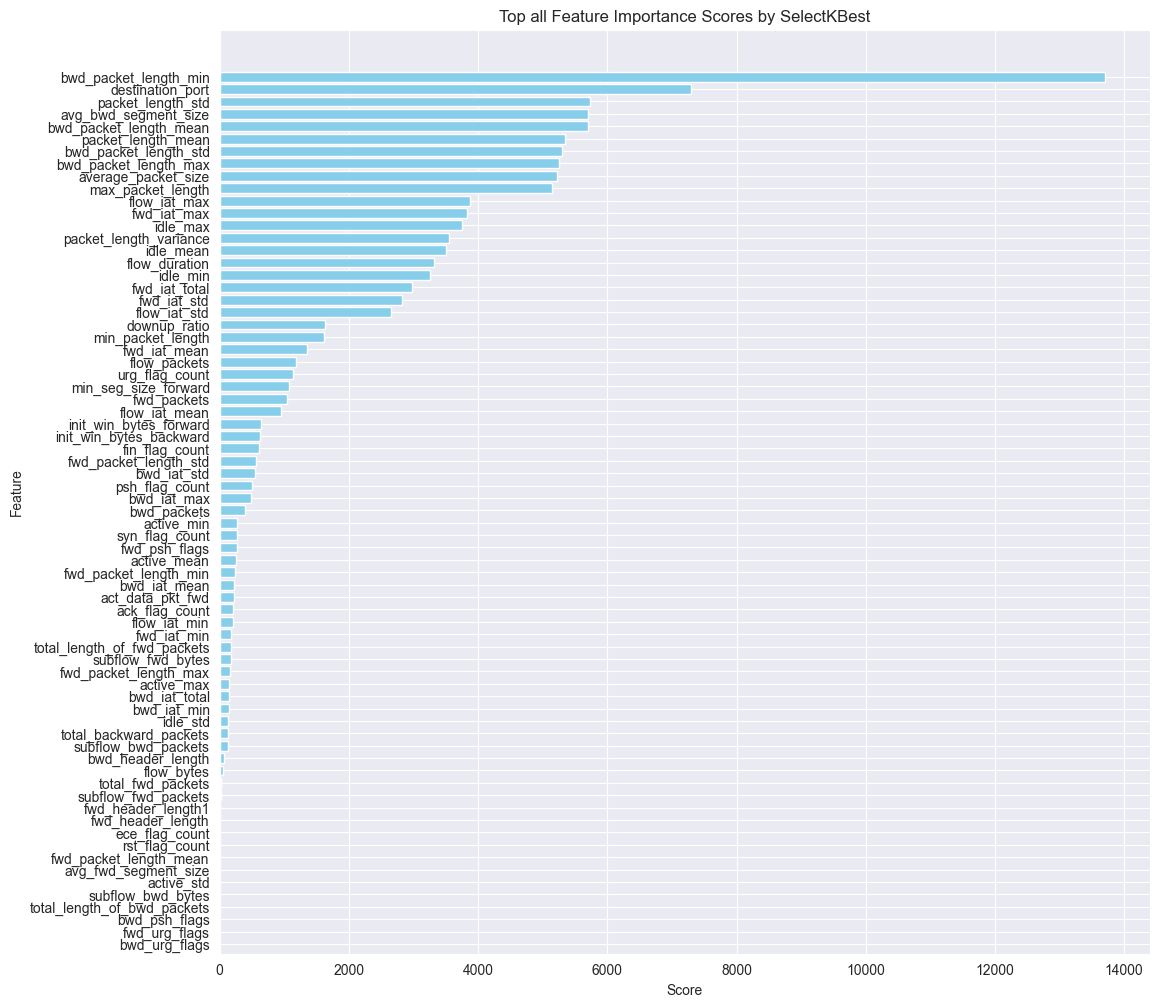

In [65]:
# get the scores for each feature
kbest_scores = selector.scores_

# get the selected feature indices
selected_indices = selector.get_support(indices=True)

# get the feature names
feature_names = X_train_standardized.columns[selected_indices]

# create a DataFrame for better visualization
feature_scores_df = pd.DataFrame({'Feature': feature_names, 'Score': kbest_scores[selected_indices]})

# sort the DataFrame by scores in descending order for better visualization
feature_scores_df = feature_scores_df.sort_values(by='Score', ascending=False)

# plot the scores
plt.figure(figsize=(12, 12))
plt.barh(feature_scores_df['Feature'], feature_scores_df['Score'], color='skyblue')
plt.xlabel('Score')
plt.ylabel('Feature')
plt.title(f'Top {k} Feature Importance Scores by SelectKBest')
plt.gca().invert_yaxis()  # to display the highest scores on top
plt.show()

In [66]:
# remove constant features
constant_features = [col for col in X_train_standardized.columns if X_train_standardized[col].nunique() == 1]

X_train_cf = X_train_standardized.drop(columns=constant_features)
X_val_cf = X_val_standardized.drop(columns=constant_features)
X_test_cf = X_test_standardized.drop(columns=constant_features)
print(f"Features after removing constant features: {X_train_cf.shape[1]}")

Features after removing constant features: 68


In [67]:
# remove features with near-zero variance using the previously created list of near-zero variance
X_train_vt = X_train_standardized.drop(columns=low_var_columns)
X_val_vt = X_val_standardized.drop(columns=low_var_columns)
X_test_vt = X_test_standardized.drop(columns=low_var_columns)
print(f"Features after removing near-zero variance: {X_train_vt.shape[1]}")

Features after removing near-zero variance: 66


In [68]:
# perform LASSO feature selection

# initialize and fit LassoCV
lasso = LassoCV(cv=5, max_iter=20000)
lasso.fit(X_train_standardized, y_train_encoded)

# select non-zero coefficients
lasso_selected_features = np.where(lasso.coef_ != 0)[0]

# transform the data to keep only the selected features
X_train_lasso = X_train_standardized.iloc[:, lasso_selected_features]
X_val_lasso = X_val_standardized.iloc[:, lasso_selected_features]
X_test_lasso = X_test_standardized.iloc[:, lasso_selected_features]
print(f"Features after LASSO: {X_train_lasso.shape[1]}")

Features after LASSO: 55


In [69]:
# perform tree-based feature importance using random forest

# initialize and fit RandomForestClassifier
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train_standardized, y_train_encoded)

# get feature importances and select top features
importances = rf.feature_importances_

# calculate the threshold using quantiles
threshold = np.quantile(importances, 0.75)

# select features with importance scores above the threshold
top_features = np.where(importances > threshold)[0]

# transform the data to keep only the selected features
X_train_rf = X_train_standardized.iloc[:, top_features]
X_val_rf = X_val_standardized.iloc[:, top_features]
X_test_rf = X_test_standardized.iloc[:, top_features]
print(f"Features after Random Forest: {X_train_rf.shape[1]}")

Features after Random Forest: 20


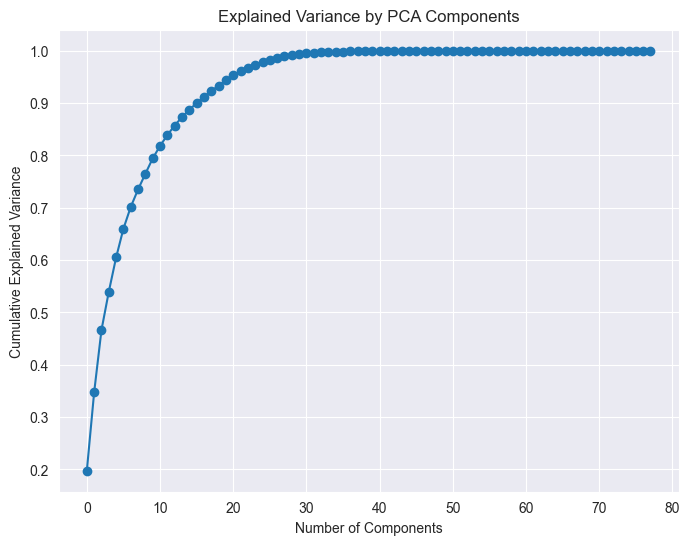

Number of components explaining 95% variance: 21
Features after PCA: 21


In [70]:
# feature extraction

# perform PCA for dimensionality reduction
pca = PCA()
X_train_pca = pca.fit_transform(X_train_standardized)
X_val_pca = pca.transform(X_val_standardized)
X_test_pca = pca.transform(X_test_standardized)

# calculate the explained variance ratio
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_explained_variance = explained_variance_ratio.cumsum()

# plot the cumulative explained variance to determine the number of components
plt.figure(figsize=(8, 6))
plt.plot(cumulative_explained_variance, marker='o')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance by PCA Components')
plt.grid(True)
plt.show()

# a common practice is to retain enough components to explain a significant portion of the variance in the data
# typically aim to keep components that explain around 95% of the variance
n_components = np.argmax(cumulative_explained_variance >= 0.95) + 1
print(f"Number of components explaining 95% variance: {n_components}")

# perform PCA with the selected number of components
pca = PCA(n_components=n_components)
X_train_pca = pca.fit_transform(X_train_standardized)
X_val_pca = pca.transform(X_val_standardized)
X_test_pca = pca.transform(X_test_standardized)
print(f"Features after PCA: {X_train_pca.shape[1]}")

# convert the data back to data frames
X_train_pca = pd.DataFrame(X_train_pca)
X_val_pca = pd.DataFrame(X_val_pca)
X_test_pca = pd.DataFrame(X_test_pca)

In [71]:
## Feature engineering has been performed, and the processed data is ready to be loaded to a SQLite database.

In [72]:
# 10. Processed Data Loading

In [73]:
# sqlite database and table names variables created for processed data
database_name = 'ide_cleaned_and_processed_db'

X_train_table_name = 'x_train_standardized_data'
X_val_table_name = 'x_val_standardized_data'
X_test_table_name = 'x_test_standardized_data'

In [74]:
# fully processed data loaded into database in separate tables
load_to_database(data_frame=X_train_standardized, db_name=database_name, t_name=X_train_table_name)
load_to_database(data_frame=X_val_standardized, db_name=database_name, t_name=X_val_table_name)
load_to_database(data_frame=X_test_standardized, db_name=database_name, t_name=X_test_table_name)

In [75]:
## Processed data has been loaded to a SQLite database, now model selection, training, and evaluation will be performed.

In [76]:
# 11. Model Selection and Training & 12. Model Evaluation

In [77]:
# model selection

# initialize the models
models = {
    "Logistic Regression": LogisticRegression(max_iter=5000),
    "SVM": SVC(probability=True, max_iter=5000),
    "k-NN": KNeighborsClassifier(),
    "Random Forest": RandomForestClassifier(),
    "Gradient Boosting": GradientBoostingClassifier()
}

# function to evaluate model
def evaluate_model(m: object, X_: Union[pd.DataFrame, np.ndarray], y_: Union[np.ndarray, pd.Series]) -> Tuple[float, float, float, float, Union[float, str], np.ndarray]:
    y_val_pred = m.predict(X_)  # this line makes predictions
    y_val_pred_prob = m.predict_proba(X_)[:, 1] if hasattr(model, 'predict_proba') else None  # this line gets probabilities if available

    acc = accuracy_score(y_, y_val_pred)
    pre = precision_score(y_, y_val_pred, average='weighted', zero_division=0)
    rec = recall_score(y_, y_val_pred, average='weighted', zero_division=0)
    f_1 = f1_score(y_, y_val_pred, average='weighted', zero_division=0)
    auc_score = roc_auc_score(y_, y_val_pred_prob) if y_val_pred_prob is not None else 'N/A'

    con_matrix = confusion_matrix(y_, y_val_pred)

    return acc, pre, rec, f_1, auc_score, con_matrix

Validation Set Results:
                     Accuracy Precision    Recall  F1 Score       AUC  \
Logistic Regression  0.981467   0.98153  0.981467  0.980764  0.991775   
SVM                  0.990734  0.990796  0.990734  0.990549   0.99635   
k-NN                 0.996911  0.996913  0.996911  0.996894  0.994944   
Random Forest        0.998456  0.998458  0.998456   0.99845  0.998642   
Gradient Boosting    0.993308  0.993272  0.993308  0.993254  0.999076   

                           Confusion Matrix  
Logistic Regression  [[330, 67], [5, 3483]]  
SVM                  [[362, 35], [1, 3487]]  
k-NN                 [[386, 11], [1, 3487]]  
Random Forest         [[391, 6], [0, 3488]]  
Gradient Boosting    [[377, 20], [6, 3482]]  


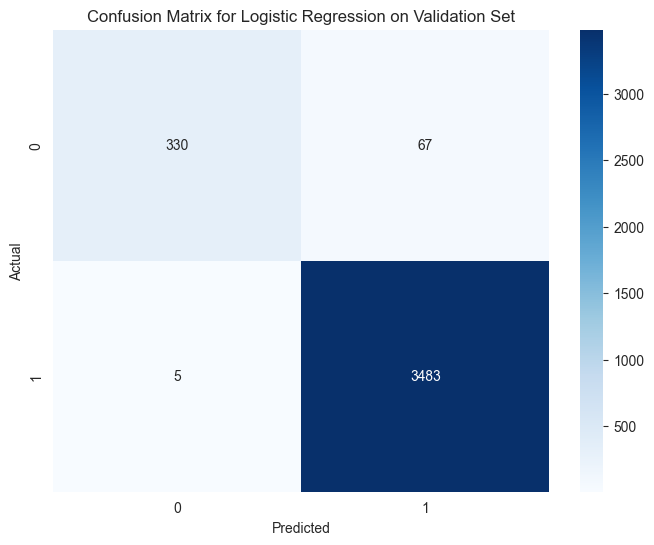

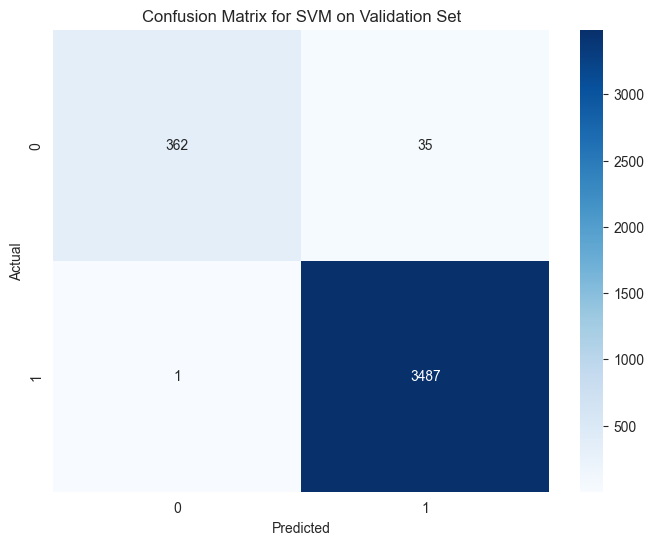

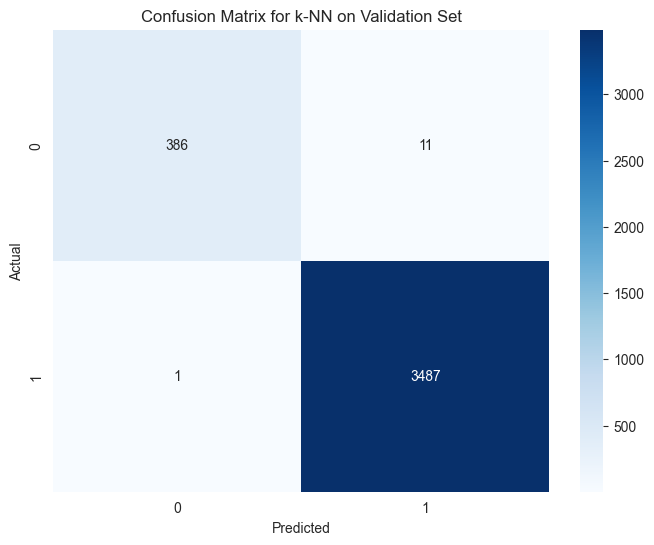

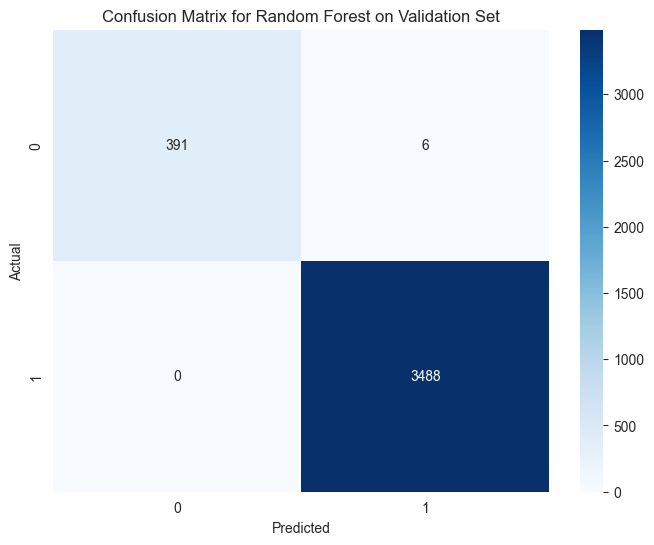

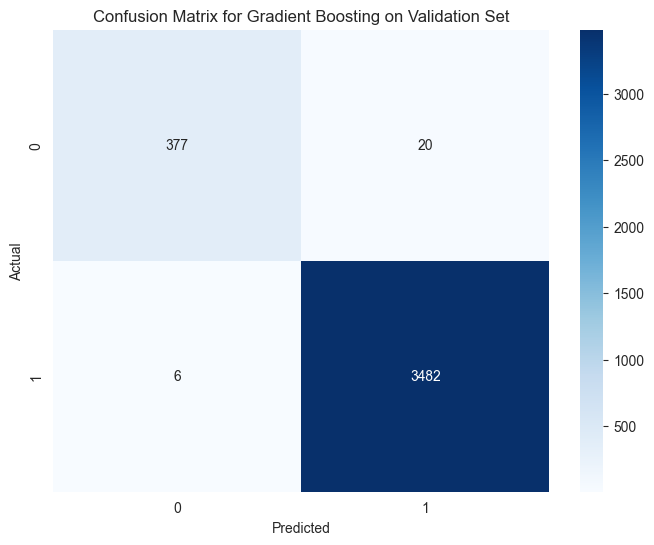

Test Set Results:
                     Accuracy Precision    Recall  F1 Score       AUC  \
Logistic Regression    0.9827  0.982646    0.9827  0.982148  0.994674   
SVM                  0.992895  0.992899  0.992895  0.992801  0.996055   
k-NN                 0.996705  0.996695  0.996705  0.996694  0.993738   
Random Forest        0.998764  0.998763  0.998764  0.998764  0.998401   
Gradient Boosting     0.99516  0.995151   0.99516  0.995124  0.999171   

                             Confusion Matrix  
Logistic Regression  [[842, 150], [18, 8701]]  
SVM                    [[929, 63], [6, 8713]]  
k-NN                   [[969, 23], [9, 8710]]  
Random Forest           [[985, 7], [5, 8714]]  
Gradient Boosting      [[952, 40], [7, 8712]]  


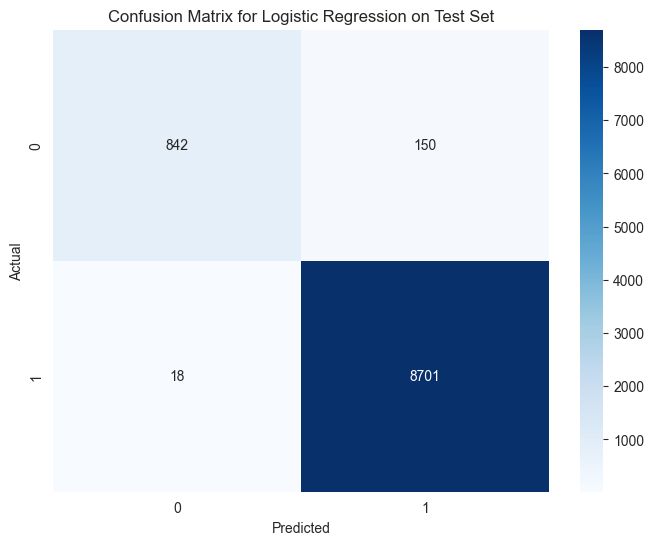

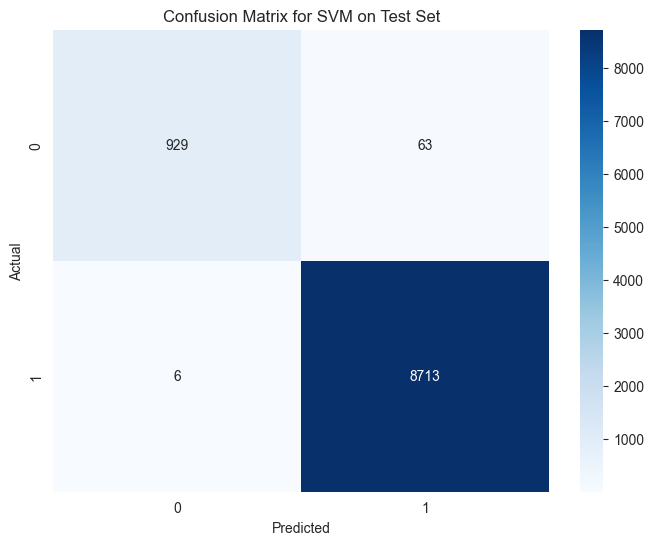

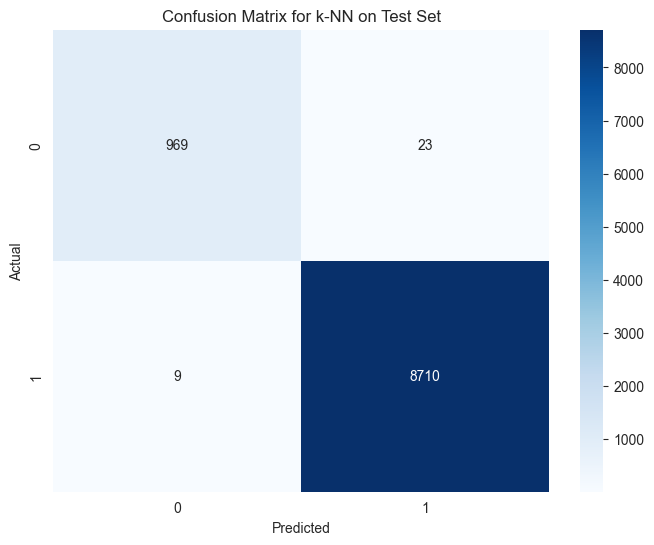

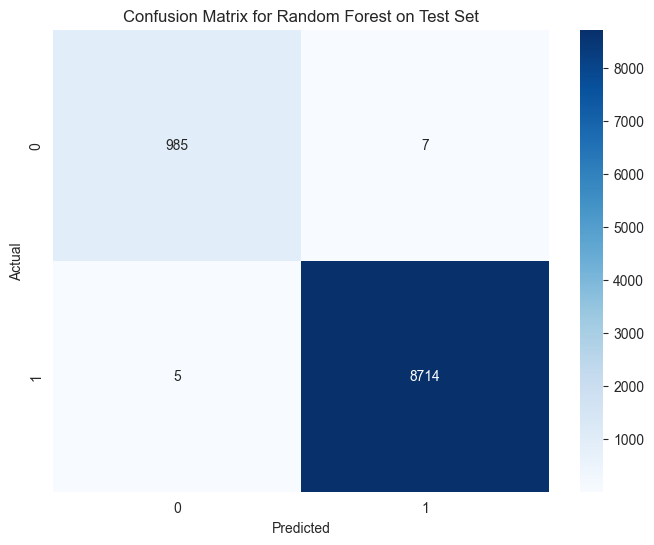

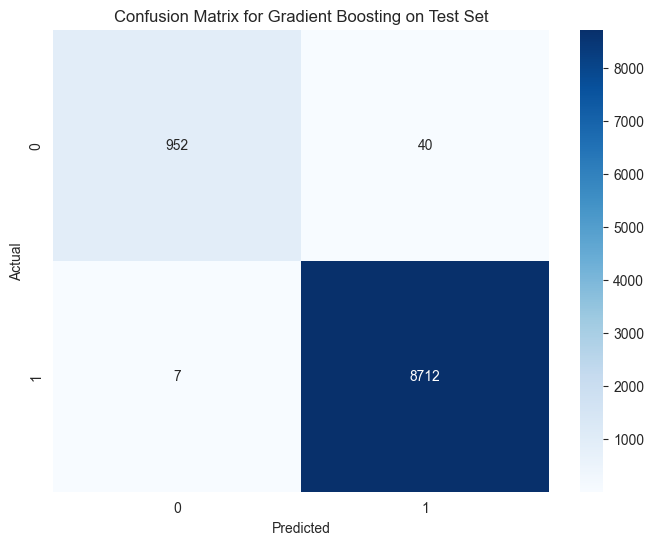

In [78]:
# model training and evaluation

# change X_train_, X_val_, X_test_ to equal the other variables that contain different features through feature selection to compare performance:
# kbest = SelectKBest features
# cf = dropped constant features
# vt = dropped low variance threshold features
# lasso = lasso selected features
# rf = random forest selected features
# pca = principal component analysis extracted features
X_train_ = X_train_pca
X_val_ = X_val_pca
X_test_ = X_test_pca

# ensure all column names are strings
X_train_.columns = X_train_.columns.astype(str)
X_val_.columns = X_val_.columns.astype(str)
X_test_.columns = X_test_.columns.astype(str)

# Dictionary to store model evaluation results for validation and test sets
train_val_results = {}
test_results = {}

for model_name, model in models.items():
    model.fit(X_train_, y_train_encoded) # this line trains the model
    
    # evaluate on validation set
    accuracy, precision, recall, f1, auc, cm = evaluate_model(model, X_val_, y_val_encoded)
    train_val_results[model_name] = {
        "Accuracy": accuracy,
        "Precision": precision,
        "Recall": recall,
        "F1 Score": f1,
        "AUC": auc,
        "Confusion Matrix": cm
    }
    
    # evaluate on the test set
    test_accuracy, test_precision, test_recall, test_f1, test_auc, test_cm = evaluate_model(model, X_test_, y_test_encoded)
    test_results[model_name] = {
        "Accuracy": test_accuracy,
        "Precision": test_precision,
        "Recall": test_recall,
        "F1 Score": test_f1,
        "AUC": test_auc,
        "Confusion Matrix": test_cm
    }

# display the model evaluation results for the validation set
train_val_results_df = pd.DataFrame(train_val_results).T
print("Validation Set Results:")
print(train_val_results_df)

# plot confusion matrices for each model on the validation set
for model_name, metrics in train_val_results.items():
    cm = metrics["Confusion Matrix"]
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix for {model_name} on Validation Set')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

# display the model evaluation results for the test set
test_results_df = pd.DataFrame(test_results).T
print("Test Set Results:")
print(test_results_df)

# plot confusion matrices for each model on the test set
for model_name, metrics in test_results.items():
    cm = metrics["Confusion Matrix"]
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix for {model_name} on Test Set')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

In [79]:
with open('model.pkl', 'wb') as file:
    pickle.dump(models, file)